In [1]:
import copy

import numpy as np
import networkx as nx
import sympy as smp
import matplotlib.pyplot as plt

from centrex_tlf import states, couplings, transitions, hamiltonian, lindblad

from effective_hamiltonian import build_effective_operators
from julia_code import sympy_matrix_to_julia_fill_hermitian

from rwa_tools import (
    create_coupling_graph,
    create_hamiltonian_symbolic,
    create_hamiltonian_rwa,
    create_transform_matrix,
)

In [2]:
plt.rcParams.update({f"font.size": 14})

In [3]:
X_states_uncoupled = states.generate_uncoupled_states_ground(Js=[0, 1, 2, 3, 4])

ham_uncoupled = hamiltonian.generate_uncoupled_hamiltonian_X(X_states_uncoupled)
ham_func = hamiltonian.generate_uncoupled_hamiltonian_X_function(ham_uncoupled)

In [4]:
Huncoupled = ham_func([0, 0, 0], [0, 0, 1e-5])
eigenvals, eigenvecs = np.linalg.eigh(Huncoupled)
H0 = np.diag(eigenvals)
HSz_unc = ham_uncoupled.HSz * 2 * np.pi

# filter small values
m = np.abs(HSz_unc) < (np.abs(HSz_unc).max() / 1e6)
HSz_unc[m] = 0

# make states and filter
QN = hamiltonian.matrix_to_states(eigenvecs, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

In [5]:
QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

# Microwave couplings

In [6]:
X_states_coupled = [qn.transform_to_coupled() for qn in X_states_uncoupled]
full_dmat_J01_z = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[:4],
    X_states_coupled[4:16],
    np.array([0, 0, 1], dtype=np.complex128),
)
full_dmat_J01_x = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[:4],
    X_states_coupled[4:16],
    np.array([1, 0, 0], dtype=np.complex128),
)
full_dmat_J12_z = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[4:16],
    X_states_coupled[16:36],
    np.array([0, 0, 1], dtype=np.complex128),
)

full_dmat_J12_x = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[4:16],
    X_states_coupled[16:36],
    np.array([1, 0, 0], dtype=np.complex128),
)

full_dmat_J23_z = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[16:36],
    X_states_coupled[36:64],
    np.array([0, 0, 1], dtype=np.complex128),
)

full_dmat_J23_x = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[16:36],
    X_states_coupled[36:64],
    np.array([1, 0, 0], dtype=np.complex128),
)


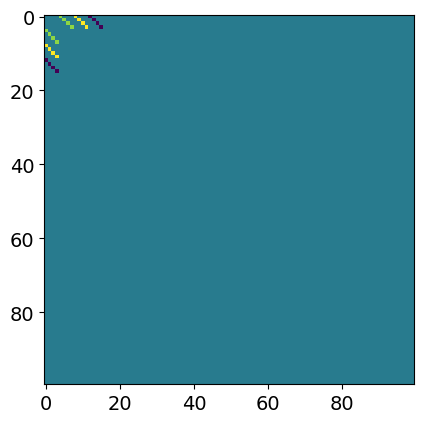

In [7]:
plt.imshow(full_dmat_J01_z.real + full_dmat_J01_x.real)

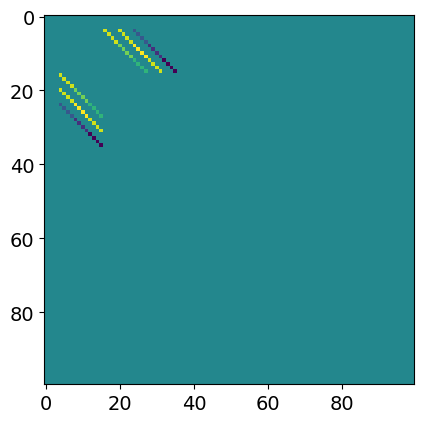

In [8]:
plt.imshow(full_dmat_J12_z.real + full_dmat_J12_x.real)

# Generate the RWA hamiltonian

In [41]:
threshold = 1e-2

trans = ["J01", "J12", "J01 bg", "J12 bg", "J23 bg"]
pols = ["z", "x"]
coupling = {tran: [] for tran in trans}


for tran, cpls in zip(
    trans,
    [
        [full_dmat_J01_z, full_dmat_J01_x],
        [full_dmat_J12_z, full_dmat_J12_x],
        [full_dmat_J01_z, full_dmat_J01_x],
        [full_dmat_J12_z, full_dmat_J12_x],
        [full_dmat_J23_z, full_dmat_J23_x],
    ],
):
    for cpl_pol in cpls:
        cpl_pol = cpl_pol.copy()
        cpl_pol[np.abs(cpl_pol) <= threshold] = 0
        vals = [vals.tolist() for vals in np.nonzero(np.triu(cpl_pol))]
        coupling[tran].extend(list(zip(*vals)))


In [36]:
nstates = len(X_states_coupled)
coupling_graph = create_coupling_graph(
    couplings=list(coupling.values()), nstates=nstates
)
ham = create_hamiltonian_symbolic(list(coupling.values()), nstates)


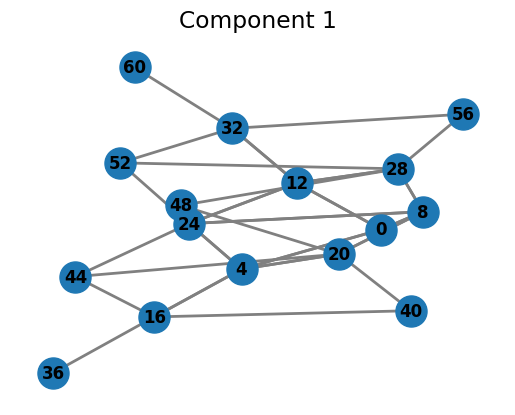

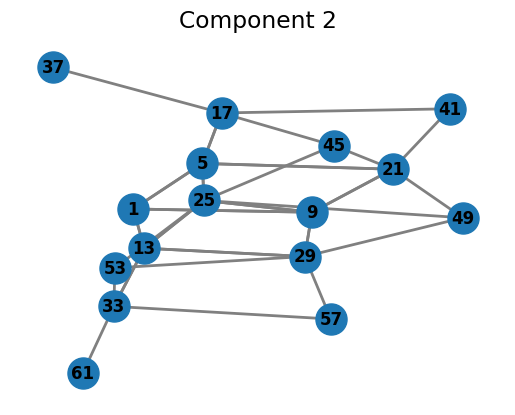

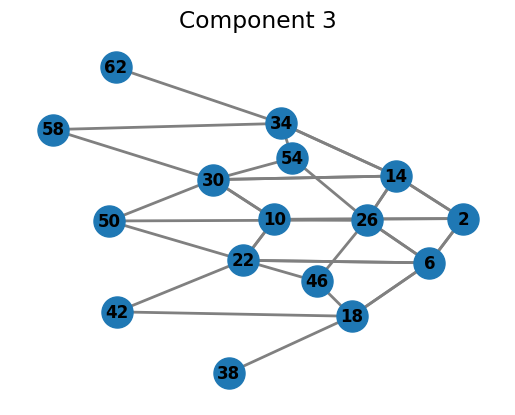

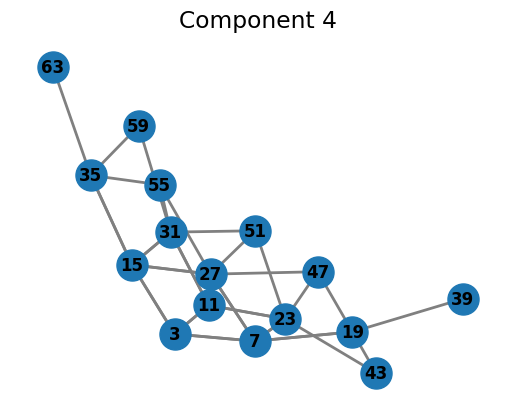

In [37]:
pos = nx.spring_layout(coupling_graph)  # Generate positions for nodes
# Draw nodes and connections
for i, comp in enumerate(nx.connected_components(coupling_graph), 1):
    # skip isolated nodes
    if len(comp) <= 1:
        continue
    subg = coupling_graph.subgraph(comp)
    pos_sub = {n: pos[n] for n in subg.nodes()}
    fig, ax = plt.subplots()
    nx.draw(
        subg,
        pos_sub,
        ax=ax,
        with_labels=True,
        node_size=500,
        font_weight="bold",
        font_size=12,
        width=2,
        edge_color="gray",
    )
    ax.set_title(f"Component {i}")

In [38]:
T = create_transform_matrix(coupling_graph)
np.diag(T)

array([1, 1, 1, 1, exp(-I*t*ω0), exp(-I*t*ω0), exp(-I*t*ω0), exp(-I*t*ω0),
       exp(-I*t*ω0), exp(-I*t*ω0), exp(-I*t*ω0), exp(-I*t*ω0),
       exp(-I*t*ω0), exp(-I*t*ω0), exp(-I*t*ω0), exp(-I*t*ω0),
       exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)),
       exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)),
       exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)),
       exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)),
       exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)),
       exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)),
       exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1)), exp(-I*t*(ω0 + ω1 + ω4)),
       exp(-I*t*(ω0 + ω1 + ω4)), exp(-I*t*(ω0 + ω1 + ω4)),
       exp(-I*t*(ω0 + ω1 + ω4)), exp(-I*t*(ω0 + ω1 + ω4)),
       exp(-I*t*(ω0 + ω1 + ω4)), exp(-I*t*(ω0 + ω1 + ω4)),
       exp(-I*t*(ω0 + ω1 + ω4)), exp(-I*t*(ω0 + ω1 + ω4)),
       exp(-I*t*(ω0 + ω1 + ω4)), exp(-I*t*(ω0 + ω1 + ω4)),
       ex

In [39]:
ham_rwa = create_hamiltonian_rwa(ham, T)

In [63]:
hrwa = ham_rwa.hamiltonian.copy()
hrwa[:20, :20]

Matrix([
[                                                           E0,                                                             0,                                                             0,                                                              0,                       a4*Ω0/2 + a52*Ω2*exp(-I*t*δ0 + I*t*δ2)/2,                                                              0,                                                              0,                                                              0, a0*Ω0/2 + a48*Ω2*exp(-I*t*δ0 + I*t*δ2)/2,                                        0,                                        0,                                        0, a5*Ω0/2 + a53*Ω2*exp(-I*t*δ0 + I*t*δ2)/2,                                        0,                                        0,                                         0,                                         0,                                         0,                                         0,                

In [44]:
trans

['J01', 'J12', 'J01 bg', 'J12 bg', 'J23 bg']

In [47]:
len(ham_rwa.coupling_identifiers)

5

In [82]:
for tran, cpls, coupling_ident in zip(
    trans,
    [
        [full_dmat_J01_z, full_dmat_J01_x],
        [full_dmat_J12_z, full_dmat_J12_x],
        [full_dmat_J01_z, full_dmat_J01_x],
        [full_dmat_J12_z, full_dmat_J12_x],
        [full_dmat_J23_z, full_dmat_J23_x],
    ],
    ham_rwa.coupling_identifiers,
):
    ncoupling_prev = 0
    for pol, cpl_pol in zip(pols, cpls):
        cpl_pol = cpl_pol.copy()
        cpl_pol[np.abs(cpl_pol) <= threshold] = 0
        indices = [vals.tolist() for vals in np.nonzero(np.triu(cpl_pol))]
        indices = list(zip(*indices))
        ncouplings = len(indices)
        for ident, index in zip(
            coupling_ident[ncoupling_prev : ncoupling_prev + ncouplings], indices
        ):
            pol_symbol = smp.Symbol(f"P{pol}", real=True)
            coupling_val = cpl_pol[*index]
            if not "bg" in tran:
                bg_symbol = smp.Symbol(f"{tran} bg")
                hrwa = hrwa.subs({ident: (coupling_val + bg_symbol) * pol_symbol})
            else:
                hrwa = hrwa.subs({ident: coupling_val * pol_symbol})


In [83]:
hrwa[:20, :20]

Matrix([
[                                                                                                                       E0,                                                                                                                         0,                                                                                                                         0,                                                                                                                         0,                      Px*Ω0*(J01 bg + 0.408248290463863)/2 + Px*Ω2*(J01 bg bg + 0.408248290463863)*exp(-I*t*δ0 + I*t*δ2)/2,                                                                                                                         0,                                                                                                                         0,                                                                                                                         0, 0.2886

In [ ]:
zμ0 = 0.0
zμ1 = 25.4e-3 * 1.125

In [ ]:
from state_prep.electric_fields import Ez_from_csv

Ez = Ez_from_csv()

E, V = np.linalg.eigh(ham_func([0, 0, Ez(-0.25)], [0, 0, 1e-5]))

QN = hamiltonian.matrix_to_states(V, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

display(QN_coupled[3].largest)
display(QN_coupled[10].largest)

print(E[10] - E[3])
print((E[10] - E[3]) / (2 * np.pi * 1e6), "MHz")

display(QN_coupled[10].largest)
display(QN_coupled[28].largest)

print(E[28] - E[10])
print((E[28] - E[10]) / (2 * np.pi * 1e6), "MHz")

ModuleNotFoundError: No module named 'state_prep'

In [ ]:
E, V = np.linalg.eigh(ham_func([0, 0, Ez(zμ0)], [0, 0, 1e-5]))

QN = hamiltonian.matrix_to_states(V, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

display(QN_coupled[3].largest)
display(QN_coupled[15].largest)

print(E[15] - E[3])
print((E[15] - E[3]) / (2 * np.pi * 1e6), "MHz")

|X, J = 0, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>

|X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

83817989701.69423
13340.047381050215 MHz


In [ ]:
E, V = np.linalg.eigh(ham_func([0, 0, Ez(zμ1)], [0, 0, 1e-5]))

QN = hamiltonian.matrix_to_states(V, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

display(QN_coupled[15].largest)
display(QN_coupled[32].largest)

print(E[32] - E[15])
print((E[32] - E[15]) / (2 * np.pi * 1e6), "MHz")

|X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

|X, J = 2, F₁ = 5/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>

167564827658.9896
26668.77061026974 MHz
